Notebook for evaluating the performance of a model on a tileset.

Exp 1: select 3 states for training and testing, train on half of the data in the state, test on the left out reagions, and evaluate the performance.
1. calculate the precision, recall and IOU for each tileset.
2. plot a distribution to see the distribution of metrics.
3. compute the scores for trained area and test area. 

Exp2: train model on entire country, test in the same region in Exp 1, find evaluate the performance. 
1. Highlight counties used for training and testing
2. Tabulate results and generate for multiple counties with missing data

In [1]:
import os
os.chdir('../')
os.getcwd()

from sklearn.metrics import jaccard_score, accuracy_score, f1_score, recall_score, precision_score

from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from random import sample 

import cv2
import numpy as np

import pandas as pd
from PIL import Image
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go


### Helper functions


In [2]:
def convert_binary(img_path):
    img = cv2.imread(img_path)
    
    lower = np.array([0, 95, 0])
    lower = np.array([0, 95, 190])
    upper = np.array([179, 255, 255])
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(img, img, mask= mask)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    _, output = cv2.threshold(output, 20, 255, cv2.THRESH_OTSU)
    
    #denoising (optional, did not run in the original code)
    #kernel = np.ones((3,3),np.uint8)
    #output = cv2.dilate(output,kernel,iterations = 1)
    #output = cv2.morphologyEx(output, cv2.MORPH_CLOSE, kernel)
    return output

In [3]:
from pathlib import Path

fake_paths = glob(r'datasets\NJNew\02Tiles\FAKE\*\*\*.png')

def save_binary(fake_paths):
    for file in tqdm(fake_paths):
        binary_path = file.replace('FAKE', 'FAKE_BINARY')
        dir_path = os.path.dirname(binary_path)
        Path(dir_path).mkdir(parents=True, exist_ok=True) # create subdirs
        
        img = convert_binary(file)
        alpha_channel = np.where(img == 255, 255, 0).astype(np.uint8)
        b_channel = img
        g_channel = img
        r_channel = img
        rgba_image = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
                
        cv2.imwrite(binary_path, rgba_image, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        
save_binary(fake_paths)

0it [00:00, ?it/s]


0.4785030189464918
0.6472804083788065
0.9617805480957031


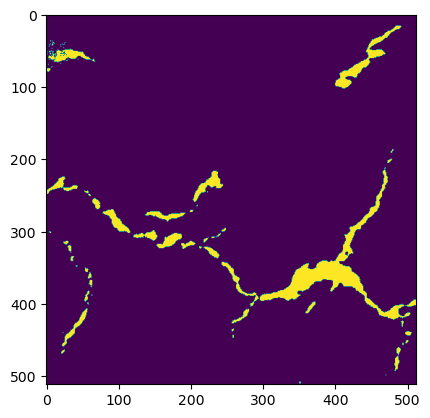

In [4]:
# test on 1 image 
true_path = glob(r'datasets\MI30\02Tiles\Flood\*\*\*.png')
pred_path = glob(r'datasets\MI30\02Tiles\FAKE\*\*\*.png')

img1 = convert_binary(true_path[1])
img2 = convert_binary(pred_path[1])

iou = jaccard_score(img1.flatten(), img2.flatten(), pos_label=255)
f1 = f1_score(img1.flatten(), img2.flatten(), pos_label=255)
accuracy = accuracy_score(img1.flatten(), img2.flatten())

print(iou)
print(f1)
print(accuracy)

plt.imshow(img1)
plt.imshow(img2)
plt.show()

0.4785030189464918
0.6472804083788065
0.9617805480957031


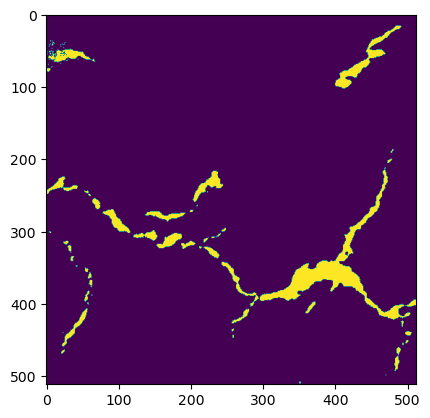

In [5]:
# test on 1 image
true_path = glob(r'datasets\MI30\02Tiles\Flood\*\*\*.png')
pred_path = glob(r'datasets\MI30\02Tiles\FAKE\*\*\*.png')

img1 = convert_binary(true_path[1])
img2 = convert_binary(pred_path[1])

iou = jaccard_score(img1.flatten(), img2.flatten(), pos_label=255)
f1 = f1_score(img1.flatten(), img2.flatten(), pos_label=255)
accuracy = accuracy_score(img1.flatten(), img2.flatten())

print(iou)
print(f1)
print(accuracy)

plt.imshow(img1)
plt.imshow(img2)
plt.show()

In [6]:
def calcualte_metric(flood_paths):
    iou_series = []
    precision_ls = []
    recall_ls = []
    f1_series = []
    for filepath in tqdm(flood_paths):
       
        target_image = Image.open(filepath).convert('L')
        empty_pixels = (np.array(target_image) == 0).sum()
        perc_empty = empty_pixels/(target_image.size[0]*target_image.size[1])
        
        if perc_empty < 0.99: #remove tiles with too much empty pixels
            try:
                #true_path = filepath.replace('Flood', 'GT')
                true_path = filepath
                fake_path = filepath.replace('Flood', 'FAKE')
                img1 = convert_binary(true_path)
                img2 = convert_binary(fake_path)
                
                # compute scores
                iou = jaccard_score(img1.flatten(), img2.flatten(), pos_label=255)
                iou_series.append(iou)
                
                f1 = f1_score(img1.flatten(), img2.flatten(), pos_label=255)
                f1_series.append(f1)
                
                precision = precision_score(img1.flatten(), img2.flatten(), pos_label=255)
                precision_ls.append(precision)
                
                recall = recall_score(img1.flatten(), img2.flatten(), pos_label=255)
                recall_ls.append(recall)
            except:
                pass        
    df = pd.DataFrame({'IOU': iou_series, 'F1-score': f1_series, 'precision': precision_ls, 'recall': recall_ls})
                
    return df

def plot_box(df):
    fig = go.Figure()
    # Use x instead of y argument for horizontal plot
    x0 = df['precision']
    x1 = df['recall']
    x2 = df['IOU']
    fig.add_trace(go.Box(x=x2, name="IOU", boxmean=True))
    fig.add_trace(go.Box(x=x1, name="Recall", boxmean=True))
    fig.add_trace(go.Box(x=x0, name="Precision", boxmean=True))

    fig.update_layout(
        margin=dict(l=20, r=20, t=20, b=20),

        width=600,
        height=250,)
    fig.show()


def plot_multibox(df):
    fig = go.Figure()
    # Use x instead of y argument for horizontal plot
    x0 = df['precision']
    x1 = df['recall']
    x2 = df['IOU']
    fig.add_trace(go.Box(x=x2, y=df['Exp'], 
                         name="IOU", boxmean=True,
                          line_width=1
                         )
                  )
    fig.add_trace(go.Box(x=x1, y=df['Exp'], 
                         name="Recall", boxmean=True,
                          line_width=1
                         )
                  )
    fig.add_trace(go.Box(x=x0, y=df['Exp'], 
                         name="Precision", boxmean=True,
                                         line_width=1
                         )
                  )

    fig.update_layout(
        boxmode='group',
        margin=dict(l=20, r=20, t=20, b=20),
        width=450,
        height=600,

        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ))
    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_traces(orientation='h')
    fig.show()

## Exp1 Testing with comparison between locally trained and nationally trained models

### Test results for New Jersey

In [19]:
true_path = r'datasets\NJ30\02Tiles\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)
nj30 = calcualte_metric(flood_paths)
print('test samples:' + str(len(nj30)))
print(nj30.mean())
plot_box(nj30)

100%|██████████| 500/500 [01:01<00:00,  8.15it/s]

test samples:463
IOU          0.788989
F1-score     0.873931
precision    0.944415
recall       0.821858
dtype: float64


NameError: name 'go' is not defined

In [37]:
plot_box(nj30)

In [ ]:
# testing NJ model performance on NJ data

true_path = r'datasets\NJ30\04Test\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)

njtest = calcualte_metric(flood_paths)
print('test samples:' + str(len(njtest)))
print(njtest.mean())
plot_box(njtest)

100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


test samples:469
IOU          0.368689
F1-score     0.518367
precision    0.656571
recall       0.480025
dtype: float64


In [ ]:
# testing National model performance on NJ data

true_path = r'datasets\USA\NJTest\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)

njnational = calcualte_metric(flood_paths)
print('test samples:' + str(len(njnational)))
print(njnational.mean())
plot_box(njnational)

100%|██████████| 500/500 [01:04<00:00,  7.78it/s]

test samples:461
IOU          0.538644
F1-score     0.674569
precision    0.805883
recall       0.610298
dtype: float64


In [ ]:
# comparing model performance between the local NJ model and the national model
njnational['Exp'] = 'NJ national'
njtest['Exp'] = 'NJ local test'
nj30['Exp'] = 'NJ local'
df = pd.concat([njnational, njtest, nj30])
plot_multibox(df)

### Test results for Michigan

In [12]:
true_path = r'datasets\MI30\02Tiles\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)

mi30 = calcualte_metric(flood_paths)
print('test samples:' + str(len(nj30)))

print(mi30.mean())
print(plot_box(mi30))

100%|██████████| 500/500 [00:40<00:00, 12.28it/s]

test samples:469
IOU          0.732697
F1-score     0.826873
precision    0.886450
recall       0.795297
dtype: float64


None


In [13]:
true_path = r'datasets\MI30\04Test\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)

mi30test = calcualte_metric(flood_paths)
print('test samples:' + str(len(mi30test)))

print(mi30test.mean())

100%|██████████| 500/500 [00:37<00:00, 13.33it/s]

test samples:248
IOU          0.378011
F1-score     0.512220
precision    0.521276
recall       0.595926
dtype: float64


In [27]:
true_path = r'datasets\USA\MITest\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)

minational = calcualte_metric(flood_paths)
print('test samples:' + str(len(minational)))
print(minational.mean())
plot_box(minational)

100%|██████████| 500/500 [00:35<00:00, 14.17it/s]

test samples:259
IOU          0.481371
F1-score     0.607790
precision    0.633398
recall       0.649569
dtype: float64


In [33]:
mi30test['Exp'] = 'MI 30 Extrapolate'
mi30['Exp'] = 'MI 30'
minational['Exp'] = 'MI National'

df = pd.concat([minational, mi30test, mi30])
plot_multibox(df)

### Test results for Texas

In [18]:
flood_path = r'datasets\TX30\02Tiles\Flood\*\*\*.png'
flood_paths = glob(flood_path)
flood_paths = sample(flood_paths, 500)

tx30 = calcualte_metric(flood_paths)
tx30.mean()

100%|██████████| 500/500 [00:45<00:00, 10.88it/s]


IOU          0.825984
F1-score     0.897968
precision    0.946342
recall       0.861922
dtype: float64

In [19]:
flood_path = r'datasets\TX30\04Test\Flood\*\*\*.png'
flood_paths = glob(flood_path)
flood_paths = sample(flood_paths, 500)

tx30test = calcualte_metric(flood_paths)
tx30test.mean()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:13<00:00,  6.77it/s]


IOU          0.469088
F1-score     0.621060
precision    0.737743
recall       0.585704
dtype: float64

In [31]:
true_path = r'datasets\USA\TXTest\Flood\*\*\*.png'
flood_paths = glob(true_path)
flood_paths = sample(flood_paths, 500)

txnational = calcualte_metric(flood_paths)
print('test samples:' + str(len(txnational)))
print(txnational.mean())
plot_box(txnational)

100%|██████████| 500/500 [00:34<00:00, 14.64it/s]

test samples:233
IOU          0.534321
F1-score     0.681773
precision    0.814167
recall       0.612593
dtype: float64


In [32]:
tx30['Exp'] = 'TX 30'
tx30test['Exp'] = 'TX 30 Test'
txnational['Exp'] = 'TX National'

df = pd.concat([txnational, tx30test, tx30])
plot_multibox(df)

## Exp2: Testing with nationally trained model in 4 regions (deprecated)

100%|██████████| 1203/1203 [01:48<00:00, 11.10it/s]

test samples:657


IOU          0.389014
F1-score     0.522392
precision    0.691261
recall       0.472676
dtype: float64

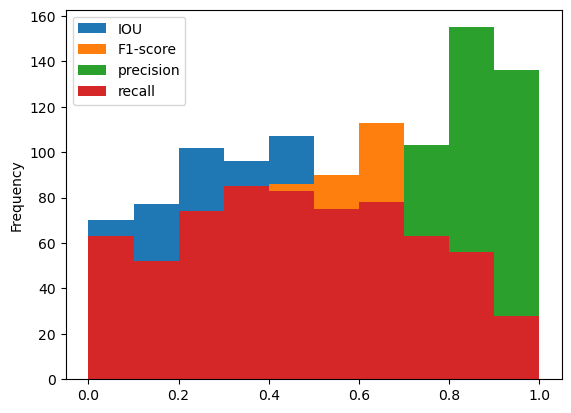

In [ ]:
# Performance of the national model on Central region
true_path = r'datasets\USA\NationalTest\Flood\*\*\*.png'

flood_paths = glob(true_path)
flood_paths = sample(flood_paths, int(len(flood_paths)/4))
usacentral = calcualte_metric(flood_paths)
print('test samples:' + str(len(usacentral)))
usacentral.plot(kind='hist')
usacentral.mean()


In [ ]:
# # interative cv2 tool to find hsv thresholds to effective crop out the flood areas from the images
# # uncomment to run
# import cv2
# import sys
# import numpy as np

# def nothing(x):
#     pass

# # Create a window
# cv2.namedWindow('image')

# # create trackbars for color change
# cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
# cv2.createTrackbar('SMin','image',0,255,nothing)
# cv2.createTrackbar('VMin','image',0,255,nothing)
# cv2.createTrackbar('HMax','image',0,179,nothing)
# cv2.createTrackbar('SMax','image',0,255,nothing)
# cv2.createTrackbar('VMax','image',0,255,nothing)

# # Set default value for MAX HSV trackbars.
# cv2.setTrackbarPos('HMax', 'image', 179)
# cv2.setTrackbarPos('SMax', 'image', 255)
# cv2.setTrackbarPos('VMax', 'image', 255)

# # Initialize to check if HSV min/max value changes
# hMin = sMin = vMin = hMax = sMax = vMax = 0
# phMin = psMin = pvMin = phMax = psMax = pvMax = 0


# pred_path = glob(r'datasets\MIRed\02Tiles\FAKE\*\*\*.png')


# img = cv2.imread(pred_path[1])
# output = img
# waitTime = 33

# while(1):

#     # get current positions of all trackbars
#     hMin = cv2.getTrackbarPos('HMin','image')
#     sMin = cv2.getTrackbarPos('SMin','image')
#     vMin = cv2.getTrackbarPos('VMin','image')

#     hMax = cv2.getTrackbarPos('HMax','image')
#     sMax = cv2.getTrackbarPos('SMax','image')
#     vMax = cv2.getTrackbarPos('VMax','image')

#     # Set minimum and max HSV values to display
#     lower = np.array([hMin, sMin, vMin])
#     upper = np.array([hMax, sMax, vMax])

#     # Create HSV Image and threshold into a range.
#     hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#     mask = cv2.inRange(hsv, lower, upper)
#     output = cv2.bitwise_and(img,img, mask= mask)

#     # Print if there is a change in HSV value
#     if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
#         print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
#         phMin = hMin
#         psMin = sMin
#         pvMin = vMin
#         phMax = hMax
#         psMax = sMax
#         pvMax = vMax

#     # Display output image
#     cv2.imshow('image',output)

#     # Wait longer to prevent freeze for videos.
#     if cv2.waitKey(waitTime) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()